(482, 469, 442) [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


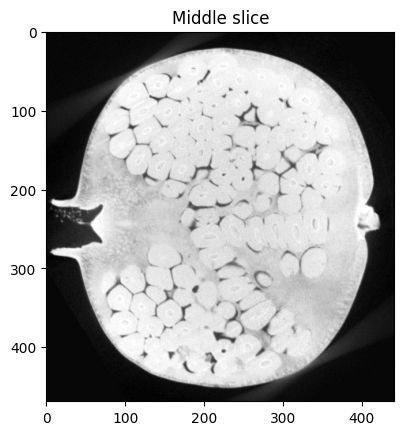

In [7]:
import nrrd
import numpy as np
import matplotlib.pyplot as plt

data, header = nrrd.read("data/pomegranate.nrrd")
print(data.shape, header["space directions"])
# (354, 348, 808), voxel size = 0.401 mm isotropic

plt.imshow(data[data.shape[0] // 2], cmap='gray')
plt.title("Middle slice")
plt.show()


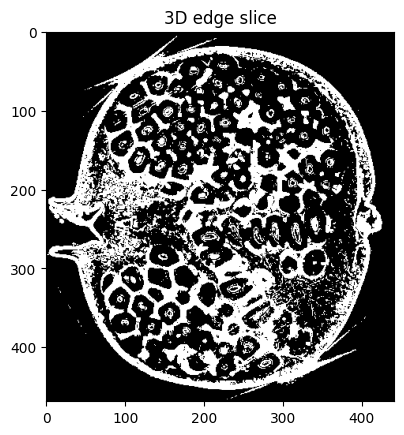

In [8]:
from scipy import ndimage

edges = ndimage.generic_gradient_magnitude(data.astype(float), ndimage.sobel)
edges = (edges > edges.mean())  # simple binary boundary mask
plt.imshow(edges[data.shape[0]//2], cmap='gray')
plt.title("3D edge slice")
plt.show()